In [1]:
import pandas as pd 
import xarray as xr
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pysumma as ps
import pysumma.plotting as psp
import matplotlib.colors as colors
os.chdir('../')

In [2]:
# Select site and read in data
name = 'Paradise' # input('Enter site name: ')
df = pd.read_csv(f'./snotel_csvs/{name}.csv', index_col=0, parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)

# open SUMMA output
summa_df = xr.open_dataset(f'../src/output/_{name}_timestep.nc')

if '_' in name:
    name = name.replace('_', ' ')

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'gini']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [21]:
summa_df.time

<xarray.DataArray 'time' (time: 1248)>
array(['2024-10-01T00:00:00.000000000', '2024-10-01T00:59:59.999986688',
       '2024-10-01T02:00:00.000013312', ..., '2024-11-21T21:00:00.000000000',
       '2024-11-21T21:59:59.999986688', '2024-11-21T23:00:00.000013312'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2024-10-01 ... 2024-11-21T23:00:00.000013312
Attributes:
    long_name:  time since time reference (instant)

In [22]:
df.index

DatetimeIndex(['2024-07-03 08:00:00', '2024-07-03 09:00:00',
               '2024-07-03 10:00:00', '2024-07-03 11:00:00',
               '2024-07-03 12:00:00', '2024-07-03 13:00:00',
               '2024-07-03 14:00:00', '2024-07-03 15:00:00',
               '2024-07-03 16:00:00', '2024-07-03 17:00:00',
               ...
               '2024-11-21 14:00:00', '2024-11-21 15:00:00',
               '2024-11-21 16:00:00', '2024-11-21 17:00:00',
               '2024-11-21 18:00:00', '2024-11-21 19:00:00',
               '2024-11-21 20:00:00', '2024-11-21 21:00:00',
               '2024-11-21 22:00:00', '2024-11-21 23:00:00'],
              dtype='datetime64[ns]', name='time', length=3396, freq=None)

In [11]:
# get depth of each layer
depth = summa_df.isel(hru=0)['iLayerHeight']
# get temperature of each layer
temp = summa_df.isel(hru=0)['mLayerTemp']
# convert to Celsius
temp = temp.where(temp<-100, temp-273.15)
# get density of each layer
density = summa_df.isel(hru=0)['mLayerVolFracWat']*1000
density = density.where(density>=0, np.nan)

In [41]:
snow_depth_obs = df.loc[pd.to_datetime(depth.time.values.min()):]['SNOWDEPTH'].resample('12h').max().shift()  * 2.54/100
# replace below zero values with 0
snow_depth_obs[snow_depth_obs < 0] = 0
# replace nan values with nan
snow_depth_obs[abs(snow_depth_obs.diff()) > 25] = np.nan
# interpolate missing values
snow_depth_obs = snow_depth_obs.interpolate()

In [39]:
# Create colomaps

# The range of temperature bins in Fahrenheit
a = np.arange(-20,5,1)

# Bins normalized between 0 and 1
norm = [(float(i)-min(a))/(max(a)-min(a)) for i in a]

# Color tuple for every bin
C = np.array([[145,0,63],
              [206,18,86],
              [231,41,138],
              [223,101,176],
              [255,115,223],
              [255,190,232],
              [255,255,255],
              [218,218,235],
              [188,189,220],
              [158,154,200],
              [117,107,177],
              [84,39,143],
              [13,0,125],
              [13,61,156],
              [0,102,194],
              [41,158,255], 
              [74,199,255], 
              [115,215,255], 
              [173,255,255],
              [48,207,194], 
              [0,153,150], 
              [18,87,87],
              [6,109,44],
              [49,163,84],
              [116,196,118],
              [161,217,155],
              [211,255,190],  
              [255,255,179], 
              [255,237,160], 
              [254,209,118], 
              [254,174,42], 
              [253,141,60], 
              [252,78,42], 
              [227,26,28], 
              [177,0,38], 
              [128,0,38], 
              [89,0,66], 
              [40,0,40]])/255.

# Create a tuple for every color indicating the normalized position on the colormap and the assigned color.
COLORS = []
for i, n in enumerate(norm):
    COLORS.append((n, C[i]))

temp_cmap = colors.LinearSegmentedColormap.from_list("Temperature", COLORS)
# The sky covered by clouds in percent (%)
a = range(50,500,50)

# Normalize the bin between 0 and 1 (uneven bins are important here)
norm = [(float(i)-min(a))/(max(a)-min(a)) for i in a]

# Color tuple for every bin
C = np.array([[36, 160, 242],
              [78, 176, 242],
              [128, 183, 248],
              [160, 200, 255],
              [210, 225, 255],
              [225, 225, 225],
              [201, 201, 201],
              [165, 165, 165],
              [110, 110, 110],
              [80, 80, 80]])

# Create a tuple for every color indicating the normalized position on the colormap and the assigned color.
COLORS = []
COLORS_r = []
for i, n in enumerate(norm):
    COLORS.append((n, np.array(C[i])/255.))
    COLORS_r.append((n, np.array(C[::-1][i])/255.))

# Create the colormap
density_cmap = colors.LinearSegmentedColormap.from_list("density", COLORS)

# create the inverse
density_cmap_r = colors.LinearSegmentedColormap.from_list("density_r", COLORS_r)

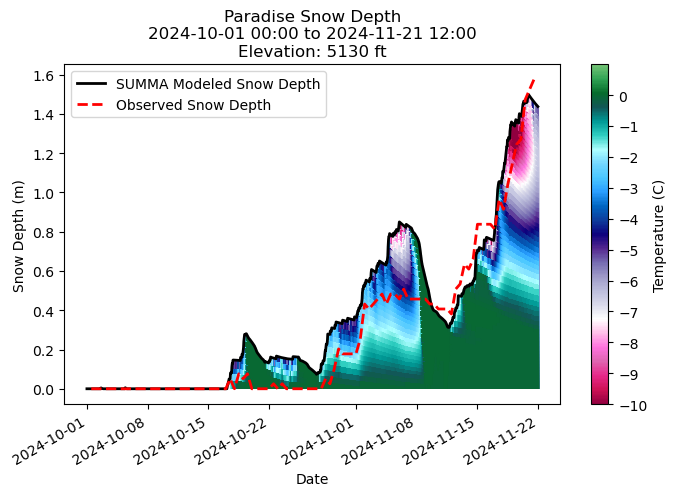

In [42]:
yfig, ax = plt.subplots(figsize=(8,5))
psp.layers(temp, depth, colormap=temp_cmap, plot_soil=False, plot_snow=True, cbar_kwargs={'label': 'Temperature (C)', 'ticks':np.arange(-10,1,1)}, variable_range=[-10, 1], ax=ax)
summa_df['scalarSnowDepth'].plot(color='k', linewidth=2, ax=ax, label='SUMMA Modeled Snow Depth');
snow_depth_obs.plot(color='red', ls='--', linewidth=2, ax=ax, label='Observed Snow Depth');
ax.legend()
ax.set_title(f"{name} Snow Depth\n{snow_depth_obs.index.min().strftime('%Y-%m-%d %H:%M')} to {snow_depth_obs.index.max().strftime('%Y-%m-%d %H:%M')}\nElevation: {df['geometry'].iloc[0][-5:-1]} ft")
ax.set_ylabel('Snow Depth (m)')
ax.set_xlabel('Date')
yfig.savefig(f"../src/output/figures/{name.replace(' ','_')}_temp_with_obs_recent.png")

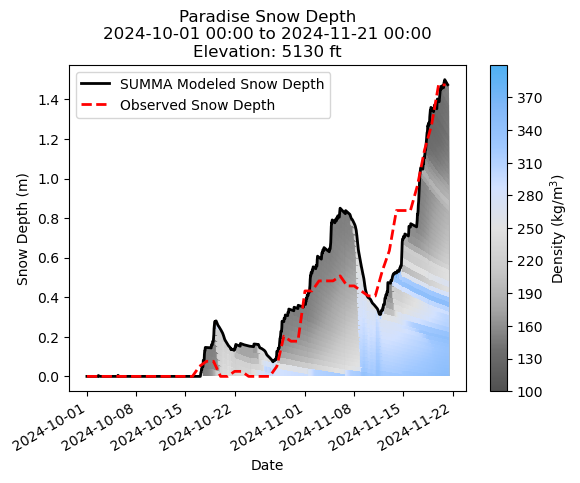

In [ ]:
yfig, ax = plt.subplots(figsize=(8,5))
psp.layers(density, depth, colormap=density_cmap_r, plot_soil=False, plot_snow=True, cbar_kwargs={'label': 'Density (kg/m$^3$)', 'ticks':np.arange(100,400,30)}, variable_range=[100, 400], ax=ax)
summa_df['scalarSnowDepth'].plot(color='k', linewidth=2, ax=ax, label='SUMMA Modeled Snow Depth');
snow_depth_obs.plot(color='red', ls='--', linewidth=2, ax=ax, label='Observed Snow Depth');
ax.legend()
ax.set_title(f"{name} Snow Depth\n{snow_depth_obs.index.min().strftime('%Y-%m-%d %H:%M')} to {snow_depth_obs.index.max().strftime('%Y-%m-%d %H:%M')}\nElevation: {df['geometry'].iloc[0][-5:-1]} ft")
ax.set_ylabel('Snow Depth (m)')
ax.set_xlabel('Date')

yfig.savefig(f"../src/output/figures/{name.replace(' ','_')}_density_with_obs_recent.png")